In [56]:
import pandas as pd
import os
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
import xml.etree.ElementTree as ET

In [196]:
#XML files that are already genereated via PDFx are assumed to be in a directory "xml"

directory="xml"
impact_dict={"title":[], "impact statement":[], "citation count":[]}

#loops through the directory, and appends the relevant information to impact_dict, which will be appended to the dataframe later
for filename in os.listdir(directory):
    if filename.endswith(".xml"):
        full_path = os.path.join(directory, filename)
        tree = ET.parse(full_path)
        root = tree.getroot()
        #get article title
        for section in root[1][0][0]:
            if section.tag=="article-title":
                title = section.text
        for section in root[1][1]:
            citations = 0
            signal = 0
            for child in section:
                if signal == 1 :
                    #print(section.text)
                    #broader_dict[filename] = section.text
                    #loop through any xrefs to count for citations
                    for xref in child:
                        if xref.tag == "xref":
                            citations +=1
                    #itertext will make sure that if there are any tags within the section, we still get the whole thing.
                    impact_dict["impact statement"].append(''.join(child.itertext()))
                    impact_dict["citation count"].append(citations)
                    impact_dict["title"].append(title)
                    signal = 0
                #focus on heading
                if str(child.text).lower() == "broader impact" and child.tag == "h1":
                    #print("It has a Broader Impact!")
                    signal=1
                elif str(child.text).lower() == "broader impacts" and child.tag == "h1":
                    signal=1

In [197]:
#create the dataframe from the dictionary

impact_statements =pd.DataFrame.from_dict(impact_dict)

In [198]:
#generate the CSV file from the dataframe

impact_statements.to_csv("output.csv",index=False)

# Analysis section

This is based off of [this](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0) guide.

In [88]:
impact_statements['processed'] = impact_statements['content'].map(lambda x: re.sub('[^a-zA-Z0-9 ]', '', x))
impact_statements['processed'] = impact_statements['processed'].map(lambda x: x.lower())

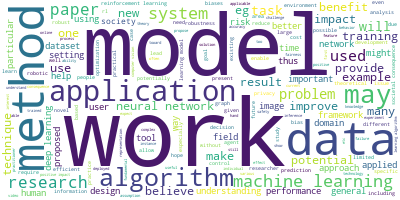

In [90]:
#create a wordcloud
# Join the different processed titles together.
long_string = ','.join(list(impact_statements['processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

C:\Users\ngear\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


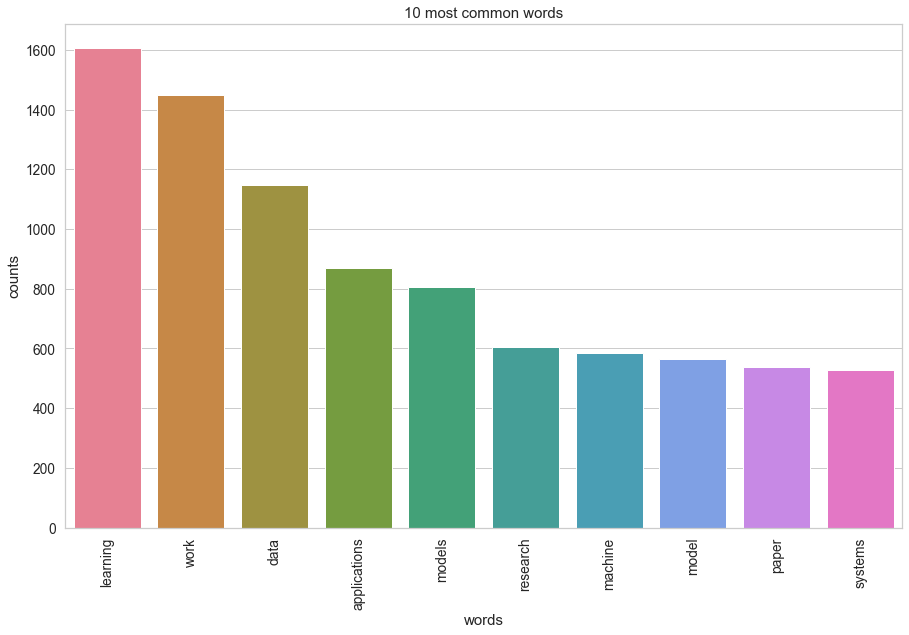

In [91]:
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(impact_statements['processed'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [94]:
warnings.simplefilter("ignore", DeprecationWarning)
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 4
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
work learning theoretical impact applications societal machine models paper methods

Topic #1:
data learning models model work training applications research used method

Topic #2:
learning work applications algorithms systems rl reinforcement methods research machine

Topic #3:
data privacy work learning research knowledge graph applications search differential


In [95]:
#%%time
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself

#if 1 == 1:
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, "rb") as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')